In [1]:
!pip install pyarabic

In [2]:
!pip install transformers

In [3]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import OneHotEncoder
import keras.backend as K
import tensorflow as tf
from keras import Input, Model 
from keras.models import load_model
from keras.layers import *
from keras import utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from transformers import AutoTokenizer, TFAutoModel, AutoConfig
import xml.etree.ElementTree as ET
from transformers import TFBertModel


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
def read_xlm_as_dataframe(file):
  tree = ET.parse(file)
  reviews = tree.getroot()
  sent_ids, sentences, targets, plarities = [], [], [], []
  for i, sentence in enumerate(reviews.iter('sentence')):
      ids,tar, p, texts = [], [], [], []
      for text in sentence.iter('text'):
        t = text.text
      for op in sentence.iter('Opinion'):
        tr = op.attrib.get('target')
        if tr !="NULL":
          tar.append(tr)
          p.append(op.attrib.get('polarity'))
      if len(tar)>1:
        for i in range(len(tar)):
          texts.append(t)
          ids.append(sentence.attrib.get('id'))
      if len(tar)==1:
        texts.append(t)
        ids.append(sentence.attrib.get('id'))

      sent_ids.extend(ids)
      sentences.extend(texts)
      targets.extend(tar)
      plarities.extend(p)    
  df = pd.DataFrame(list(zip(sent_ids, sentences, targets, plarities)), columns=['id', 'text', 'term', 'polarity'])  
  return df  

In [5]:
reviews_train = read_xlm_as_dataframe("/kaggle/input/new-dataset/AR_Hotels_Train_SB1 (2).xml")
reviews_test = read_xlm_as_dataframe("/kaggle/input/new-dataset/AR_HOTE_SB1_TEST (3).xml")


In [6]:
import pyarabic.araby as araby

In [7]:
import re

In [8]:
def text_preprocessing(text):
    ## Remove punctuation marks
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)  
    ## Remove numbers
    text = re.sub("\d+", " ", text)
    ## Remove diacritics
    text = normalizeArabic(text)
    ## remove non-Arabic letters and digits
    text = re.sub('[A-Za-z]+',' ',text)
    text = re.sub(r'\\u[A-Za-z0-9\\]+',' ',text)
    
    return text
def normalizeArabic(text):
    text = text.strip()
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    noise = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(noise, '', text)
    text = re.sub(r'(.)\1+', r"\1\1", text) # Remove longation
    return araby.strip_tashkeel(text)

In [9]:
reviews_train['text'] = reviews_train['text'].apply(lambda x:text_preprocessing(x))
reviews_train['term'] = reviews_train['term'].apply(lambda x:text_preprocessing(x))
reviews_test['text'] = reviews_test['text'].apply(lambda x:text_preprocessing(x))
reviews_test['term'] = reviews_test['term'].apply(lambda x:text_preprocessing(x))

In [10]:
class_map={"negative":0, "neutral":1, "positive":2}
reviews_train['label'] = reviews_train['polarity'].map(class_map)
reviews_test['label'] = reviews_test['polarity'].map(class_map)

In [11]:
def get_one_hot_labels():
  enc = OneHotEncoder(handle_unknown='ignore')
  train_y = enc.fit_transform(reviews_train['label'].values.reshape(-1, 1)).todense()
  test_y = enc.fit_transform(reviews_test['label'].values.reshape(-1, 1)).todense()
  return train_y, test_y, enc

In [12]:
reviews_train['polarity'].value_counts()

polarity
positive    5819
negative    3141
neutral      660
Name: count, dtype: int64

In [13]:
reviews_train['label'].value_counts()

label
2    5819
0    3141
1     660
Name: count, dtype: int64

In [14]:
train_y, test_y, enc = get_one_hot_labels()

In [15]:
tokenizer = AutoTokenizer.from_pretrained('aubmindlab/bert-base-arabertv02')

tokenizer_config.json:   0%|          | 0.00/381 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/825k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [16]:
def tokenize(sentences,aspects, tokenizer):
    input_ids, input_masks, input_segments = [], [], []
    for i in range(len(sentences)):
        inputs = tokenizer.encode_plus(sentences[i], aspects[i],
                                       add_special_tokens=True, 
                                       max_length=100, 
                                       pad_to_max_length=True, 
                                       return_attention_mask=True, 
                                       return_token_type_ids=True, 
                                       truncation=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])       
        i=i+1
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32')


In [17]:
X_train = tokenize(reviews_train['text'],reviews_train['term'],tokenizer)
X_test = tokenize(reviews_test['text'],reviews_test['term'],tokenizer)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [18]:
configb = AutoConfig.from_pretrained('aubmindlab/bert-base-arabertv02', output_hidden_states=True, output_attentions=True)
arabertembedding = TFAutoModel.from_pretrained('aubmindlab/bert-base-arabertv02', config=configb)

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already u

In [19]:
# Util classes
from keras import initializers, regularizers, constraints
import keras
class Attention(keras.layers.Layer):
    def __init__(self,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, return_attention=False,
                 **kwargs):
        self.supports_masking = True
        self.return_attention = return_attention
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(Attention, self).__init__(**kwargs)


    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        eij = K.squeeze(K.dot(x, K.expand_dims(self.W)), axis=-1)

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        weighted_input = x * K.expand_dims(a)

        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return input_shape[0], input_shape[-1]

In [20]:
input_ids_in = Input(shape=(100,), dtype='int32')
input_masks_in = Input(shape=(100,), dtype='int32')
embedding_layer = arabertembedding(input_ids=input_ids_in, attention_mask=input_masks_in)[0]
GRU_out = Bidirectional(GRU(128, return_sequences=True))(embedding_layer)
X2 = tf.keras.layers.Dropout(0.1)(GRU_out)
sentence, word_scores = Attention(return_attention=True, name="attention_vec")(X2)
X3 = tf.keras.layers.Dropout(0.1)(sentence)

# Additional layer (add more if needed)
additional_layer = Bidirectional(GRU(64, return_sequences=True))(embedding_layer)
pooled_additional = tf.keras.layers.GlobalMaxPooling1D()(additional_layer)
X_additional = tf.keras.layers.Dropout(0.1)(pooled_additional)

# Concatenate the outputs
concatenated_layers = Concatenate()([X3, X_additional])

X4 = tf.keras.layers.Dense(64, activation='relu')(concatenated_layers)
X5 = tf.keras.layers.Dropout(0.1)(X4)
Xlast = tf.keras.layers.Dense(len(enc.categories_[0]), activation='softmax')(X5)
model = Model(inputs=[input_ids_in, input_masks_in], outputs=Xlast)

In [21]:
#Add GRU Only After Concatenation
from keras.layers import Input
input_ids_in = Input(shape=(100,), dtype='int32')
input_masks_in = Input(shape=(100,), dtype='int32')

# Embedding Layer
embedding_layer = arabertembedding(input_ids=input_ids_in, attention_mask=input_masks_in)[0]

# Bidirectional GRU Layer after Concatenation
concatenated_layers = Concatenate()([embedding_layer, embedding_layer])  # You might need to adjust this based on your architecture
gru_output = Bidirectional(GRU(64, return_sequences=True))(concatenated_layers)
pooled_gru = GlobalMaxPooling1D()(gru_output)
X_gru = Dropout(0.1)(pooled_gru)

# Dense Layers
X_dense = Dense(64, activation='relu')(X_gru)
X_dense_dropout = Dropout(0.1)(X_dense)

# Output Layer
X_last = Dense(len(enc.categories_[0]), activation='softmax')(X_dense_dropout)

# Model
model= Model(inputs=[input_ids_in, input_masks_in], outputs=X_last)


In [22]:
#Add Attention Only After Concatenation
input_ids_in = Input(shape=(100,), dtype='int32')
input_masks_in = Input(shape=(100,), dtype='int32')

# Embedding Layer
embedding_layer = arabertembedding(input_ids=input_ids_in, attention_mask=input_masks_in)[0]

# Concatenate the outputs
concatenated_layers = Concatenate()([embedding_layer, embedding_layer])  # You might need to adjust this based on your architecture

# Attention Layer
sentence, word_scores = Attention(return_attention=True, name="attention_vec")(concatenated_layers)
X_attention = Dropout(0.1)(sentence)

# Dense Layers
X_dense = Dense(64, activation='relu')(X_attention)
X_dense_dropout = Dropout(0.1)(X_dense)

# Output Layer
X_last = Dense(len(enc.categories_[0]), activation='softmax')(X_dense_dropout)

# Model
model = Model(inputs=[input_ids_in, input_masks_in], outputs=X_last)


In [23]:
#Add Both GRU and Attention After Concatenation

input_ids_in = Input(shape=(100,), dtype='int32')
input_masks_in = Input(shape=(100,), dtype='int32')

# Embedding Layer
embedding_layer = arabertembedding(input_ids=input_ids_in, attention_mask=input_masks_in)[0]

# Concatenate the outputs
concatenated_layers = Concatenate()([embedding_layer, embedding_layer])  # You might need to adjust this based on your architecture

# Bidirectional GRU Layer
gru_output = Bidirectional(GRU(64, return_sequences=True))(concatenated_layers)
pooled_gru = GlobalMaxPooling1D()(gru_output)
X_gru = Dropout(0.1)(pooled_gru)

# Attention Layer
sentence, word_scores = Attention(return_attention=True, name="attention_vec")(concatenated_layers)
X_attention = Dropout(0.1)(sentence)

# Concatenate the outputs of GRU and Attention
concatenated_outputs = Concatenate()([X_gru, X_attention])

# Dense Layers
X_dense = Dense(64, activation='relu')(concatenated_outputs)
X_dense_dropout = Dropout(0.1)(X_dense)

# Output Layer
X_last = Dense(len(enc.categories_[0]), activation='softmax')(X_dense_dropout)

# Model
model = Model(inputs=[input_ids_in, input_masks_in], outputs=X_last)


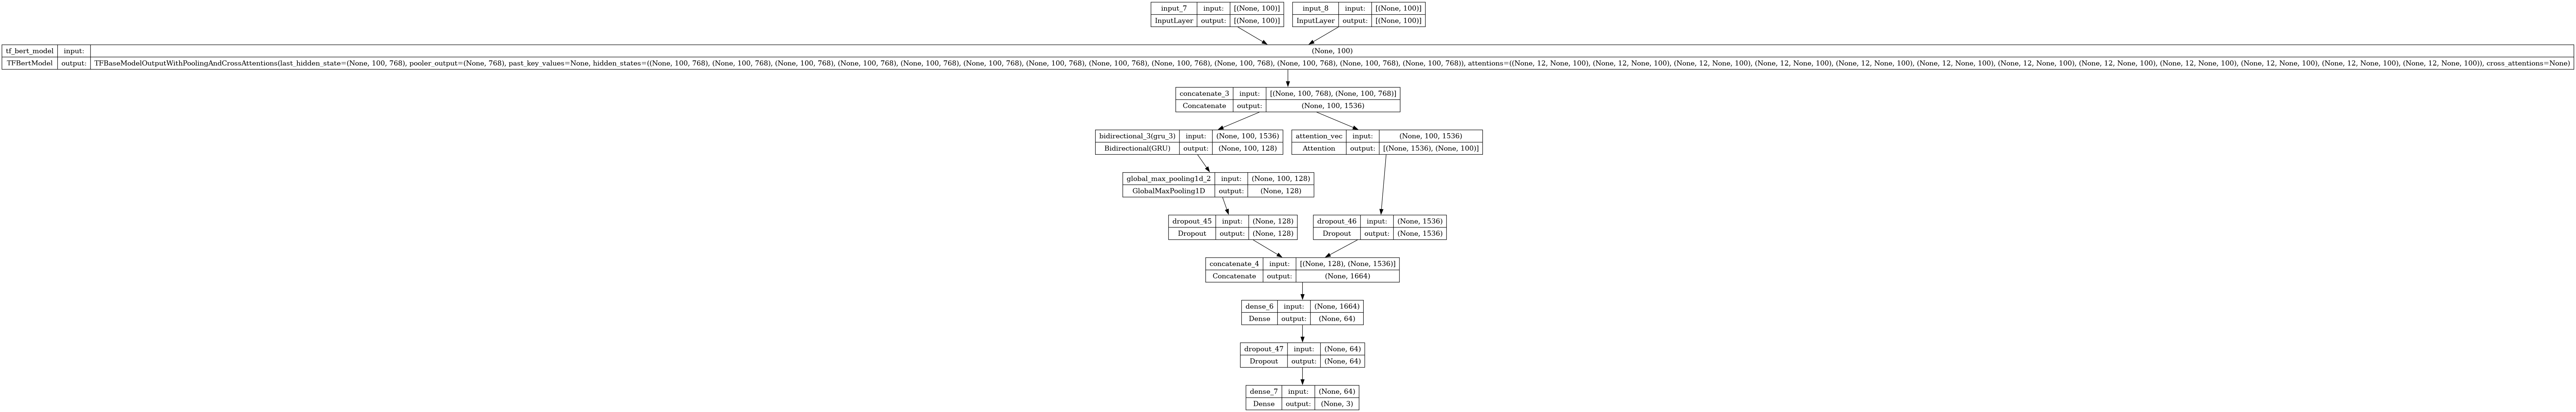

In [24]:
utils.plot_model(model, show_shapes=True)

In [25]:
# Define the model checkpoint callback
checkpoint = ModelCheckpoint(
    "SemEval2016_arabic/aspect_model_hotel.h5",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# Define the early stopping callback
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Define the Adam optimizer with a learning rate of 1e-5
optim = Adam(learning_rate=1e-5)

# Compile the model with categorical crossentropy loss and the Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

# Train the model with the defined callbacks and optimizer
history = model.fit(
    X_train, train_y,
    validation_split=0.1,
    epochs=15,
    batch_size=24,
    callbacks=[checkpoint, early_stop],
    verbose=1
)

Epoch 1/15
361/361 [==============================] - ETA: 0s - loss: 0.4612 - accuracy: 0.8392
Epoch 1: val_accuracy improved from -inf to 0.89813, saving model to SemEval2016_arabic/aspect_model_hotel.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


361/361 [==============================] - 251s 560ms/step - loss: 0.4612 - accuracy: 0.8392 - val_loss: 0.2863 - val_accuracy: 0.8981
Epoch 2/15
361/361 [==============================] - ETA: 0s - loss: 0.2824 - accuracy: 0.8969
Epoch 2: val_accuracy improved from 0.89813 to 0.90333, saving model to SemEval2016_arabic/aspect_model_hotel.h5
361/361 [==============================] - 197s 546ms/step - loss: 0.2824 - accuracy: 0.8969 - val_loss: 0.2405 - val_accuracy: 0.9033
Epoch 3/15
361/361 [==============================] - ETA: 0s - loss: 0.2085 - accuracy: 0.9254
Epoch 3: val_accuracy improved from 0.90333 to 0.91164, saving model to SemEval2016_arabic/aspect_model_hotel.h5
361/361 [==============================] - 196s 542ms/step - loss: 0.2085 - accuracy: 0.9254 - val_loss: 0.2272 - val_accuracy: 0.9116
Epoch 4/15
361/361 [==============================] - ETA: 0s - loss: 0.1560 - accuracy: 0.9441
Epoch 4: val_accuracy improved from 0.91164 to 0.91684, saving model to SemEval20

In [26]:
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

In [27]:
history = model.fit(X_train, train_y, validation_split=0.1, epochs=10, batch_size=24, callbacks=[checkpoint, early_stop], verbose=1)


Epoch 1/10
361/361 [==============================] - ETA: 0s - loss: 0.0928 - accuracy: 0.9665
Epoch 1: val_accuracy did not improve from 0.91996
361/361 [==============================] - 216s 542ms/step - loss: 0.0928 - accuracy: 0.9665 - val_loss: 0.2781 - val_accuracy: 0.9064
Epoch 2/10
361/361 [==============================] - ETA: 0s - loss: 0.0679 - accuracy: 0.9755
Epoch 2: val_accuracy did not improve from 0.91996
361/361 [==============================] - 191s 529ms/step - loss: 0.0679 - accuracy: 0.9755 - val_loss: 0.3529 - val_accuracy: 0.9106
Epoch 3/10
361/361 [==============================] - ETA: 0s - loss: 0.0535 - accuracy: 0.9816
Epoch 3: val_accuracy did not improve from 0.91996
361/361 [==============================] - 191s 530ms/step - loss: 0.0535 - accuracy: 0.9816 - val_loss: 0.3526 - val_accuracy: 0.9075
Epoch 4/10
361/361 [==============================] - ETA: 0s - loss: 0.0480 - accuracy: 0.9851
Epoch 4: val_accuracy did not improve from 0.91996
361/361

In [28]:
custom_objects={"arabertembedding": TFAutoModel,'TFBertModel':TFBertModel, "Attention": Attention}

In [29]:
best_model= tf.keras.models.load_model('SemEval2016_arabic/aspect_model_hotel.h5',custom_objects=custom_objects)

In [30]:
best_model.evaluate(X_test, test_y)

75/75 [==============================] - 20s 221ms/step - loss: 0.3423 - accuracy: 0.9030


[0.3422926962375641, 0.9030354022979736]

In [31]:
probs = best_model.predict(X_test)
preds = np.argmax(probs, axis=1)
classes = list(class_map.keys())
report = classification_report(reviews_test['label'].values,preds, target_names=classes)
print(report)

75/75 [==============================] - 20s 223ms/step
              precision    recall  f1-score   support

    negative       0.91      0.95      0.93       784
     neutral       0.55      0.45      0.49       162
    positive       0.93      0.93      0.93      1426

    accuracy                           0.90      2372
   macro avg       0.80      0.78      0.78      2372
weighted avg       0.90      0.90      0.90      2372



In [32]:
model_att = Model(inputs=best_model.input, \
                            outputs=[best_model.output, best_model.get_layer('attention_vec').output[0]])

In [33]:
label_probs, attentions = model_att.predict((X_test[0][20].reshape(1,-1), X_test[1][20].reshape(1,-1)))

1/1 [==============================] - 3s 3s/step


In [34]:
attentions

array([[ 0.40369847,  1.2828654 , -0.5096078 , ...,  0.07471892,
         1.7099679 , -0.13490212]], dtype=float32)

In [35]:
from IPython.core.display import display, HTML

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb
    
def attention2color(attention_score, label):
    r = 255 - int(attention_score * 255)
    # if label == 0:
    #   color = rgb_to_hex((255, 0, r))
    # elif label == 1:
    #   color = rgb_to_hex((r,255, r))
    # else:
    color = rgb_to_hex((255,r, r))
    return str(color)


def visualize_attention():
    # Make new model for output predictions and attentions
    '''
    model.get_layer('attention_vec').output:
    attention_vec (Attention)    [(None, 128), (None, 54)] <- We want (None,54) that is the word att
    '''
    
    model_att = Model(inputs=best_model.input, \
                            outputs=[best_model.output, best_model.get_layer('attention_vec').output[-1]])
    idx = np.random.randint(low = 0, high=X_test[0].shape[0]) # Get a random test
    tokenized_sample = np.trim_zeros(X_test[0][idx]) # Get the tokenized text
    label_probs, attentions = model_att.predict((X_test[0][idx].reshape(1,-1), X_test[1][idx].reshape(1,-1))) # Perform the prediction
    po=reviews_test['polarity'][idx]
    aspect=reviews_test['term'][idx]
    # print(idx)
    # Get decoded text and labels
    decoded_text = tokenizer.decode(tokenized_sample)
    #print(decoded_text)

    # Get classification
    label = np.argmax(label_probs) # Only one
    # print(label)
    #label2id = ['negative', 'neutral', 'positive']

    # Get word attentions using attenion vector
    token_attention_dic = {}
    max_score = 0.0
    min_score = 0.0

    attentions_text = attentions[0,-len(tokenized_sample):]
    attentions_text = (attentions_text - np.min(attentions_text)) / (np.max(attentions_text) - np.min(attentions_text))
    for token, attention_score in zip(decoded_text.split(), attentions_text):
        #print(token, attention_score)
        if token not in ["[SEP]", "[CLS]"]:
          token_attention_dic[token] = attention_score
        

    # Build HTML String to viualize attentions
    html_text = "<hr><p style='font-size: large'><b>Text:  </b>"
    html_text1 = "<hr><p style='font-size: large'><b>Aspect:  </b>"+aspect
    html_text2 = "<hr><p style='font-size: large'><b>Polarity:  </b>"+po
    for token, attention in token_attention_dic.items():
        html_text += "<span style='background-color:{};'>{} <span> ".format(attention2color(attention, label), token)
        

    
    # Display text enriched with attention scores 
    display(HTML(html_text))
    display(HTML(html_text1))
    display(HTML(html_text2))
    # PLOT EMOTION SCORES
    _labels = ['negative', 'neutral', 'positive']

    probs = label_probs
    plt.figure(figsize=(5,1.5))
    plt.bar(np.arange(len(_labels)), probs.squeeze(), align='center', alpha=0.7, color=[ 'red', 'yellow', 'green'])
    plt.xticks(np.arange(len(_labels)), _labels)
    plt.ylabel('Scores')
    plt.show()

/tmp/ipykernel_43/2743705657.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


1/1 [==============================] - 4s 4s/step


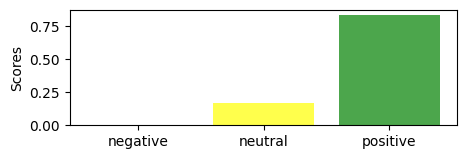

1/1 [==============================] - 4s 4s/step


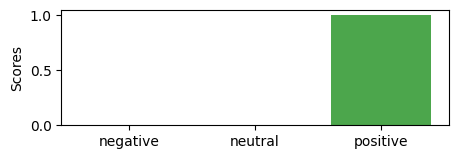

1/1 [==============================] - 3s 3s/step


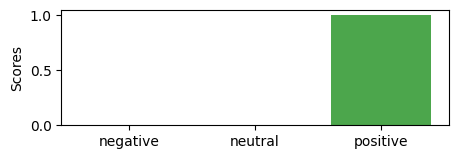

1/1 [==============================] - 3s 3s/step


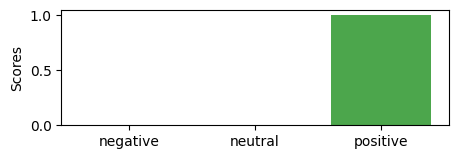

1/1 [==============================] - 4s 4s/step


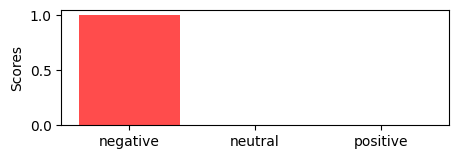

In [ ]:
for i in range(10):
    visualize_attention()

In [ ]:

def tokenize_one_sen(sentence,aspect, tokenizer):
    input_ids, input_masks, input_segments = [], [], []
   
    inputs = tokenizer.encode_plus(sentence, aspect,
                                       add_special_tokens=True, 
                                       max_length=100, 
                                       pad_to_max_length=True, 
                                       return_attention_mask=True, 
                                       return_token_type_ids=True, truncation=True)
    input_ids.append(inputs['input_ids'])
    input_masks.append(inputs['attention_mask'])
    input_segments.append(inputs['token_type_ids'])
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32')



In [ ]:
text='وكذلك اود ان اشير الي حسن الضيافه والاستقبال من طاقم الاستقبال و اخص المستر اسامه خليفه لتفانيه في خدمه العملاء'
aspect='حسن الضيافه'

In [ ]:
text=text_preprocessing(text)
aspect=text_preprocessing(aspect)

In [ ]:
check_sen=tokenize_one_sen(text,aspect,tokenizer)

In [ ]:
output = best_model.predict(check_sen)
label = output.argmax()
sentiment = enc.categories_[0][label]
sentiment